In [19]:
%load_ext autoreload
%autoreload 2

In [38]:
from cot_probing.swapping import (
    process_successful_swaps,
    SuccessfulSwap,
    LayersFspPatchResult,
    PatchedLogitsProbs,
)
from cot_probing import DATA_DIR
from cot_probing.typing import *
from transformers import AutoTokenizer
import pickle
from tqdm.auto import tqdm, trange


seed_i = 1
responses_path = DATA_DIR / "responses_by_seed_8B.pkl"
swap_results_path = DATA_DIR / f"swap_results_by_q_seed_i_{seed_i}_8B_pos5_tok3_p5.pkl"
model_id = "hugging-quants/Meta-Llama-3.1-8B-BNB-NF4-BF16"
tokenizer = AutoTokenizer.from_pretrained(model_id)

successful_swaps_by_q = process_successful_swaps(
    responses_path=responses_path,
    swap_results_path=swap_results_path,
    tokenizer=tokenizer,
    seed_i=seed_i,
)
with open(
    DATA_DIR
    / f"q+cot_patch_results_8B_LB1__responses_by_seed_8B__swap_results_by_q_seed_i_{seed_i}_8B_pos5_tok3_p5.pkl",
    "rb",
) as f:
    patch_results_by_swap_by_q = pickle.load(f)

In [39]:
for i, (successful_swaps, patch_results_by_swap) in enumerate(
    zip(successful_swaps_by_q, patch_results_by_swap_by_q)
):
    n_really_successful_swaps = sum(fpr is not None for fpr in patch_results_by_swap)
    print(
        f"q_idx: {i}, len(successful_swaps): {len(successful_swaps)}, {n_really_successful_swaps=}"
    )

    # n_unfai_to_fai = sum(
    #     1 for swap in successful_swaps if swap.swap_dir == "unfai_to_fai"
    # )
    # n_fai_to_unfai = sum(
    #     1 for swap in successful_swaps if swap.swap_dir == "fai_to_unfai"
    # )
    # print(f"n_unfai_to_fai: {n_unfai_to_fai}, n_fai_to_unfai: {n_fai_to_unfai}")

q_idx: 0, len(successful_swaps): 0, n_really_successful_swaps=0
q_idx: 1, len(successful_swaps): 1, n_really_successful_swaps=0
q_idx: 2, len(successful_swaps): 6, n_really_successful_swaps=6
q_idx: 3, len(successful_swaps): 1, n_really_successful_swaps=1
q_idx: 4, len(successful_swaps): 4, n_really_successful_swaps=1


In [40]:
import matplotlib.pyplot as plt


def plot_heatmap(values, title, labels, fai_tok_str, unfai_tok_str):
    plt.imshow(
        values,
        cmap="RdBu",
        origin="lower",
        vmin=-max(abs(np.min(values)), abs(np.max(values))),
        vmax=max(abs(np.min(values)), abs(np.max(values))),
    )
    plt.title(f"{title} for `{fai_tok_str}` -> `{unfai_tok_str}`")
    plt.colorbar()
    # plt.xticks(range(len(labels)), labels)
    plt.show()

In [41]:
def get_patch_values(
    plp_by_tok_by_layers: dict[tuple[int, ...], list[PatchedLogitsProbs]],
    prob_or_logit: Literal["prob", "logit"],
    direction: Literal["bia_to_unb", "unb_to_bia"],
) -> np.ndarray:
    attr = f"{prob_or_logit}_diff_change_{direction}"
    values = []
    for layers, plp_by_tok in plp_by_tok_by_layers.items():
        values.append([getattr(plp, attr) for plp in plp_by_tok])
    return np.array(values)

q_idx=0

q_idx=1

q_idx=2

swap_idx=0
34.86%
`304` -> `305`

top_seq_pos=array([70, 71, 72])
Last question: `: Is 45 days from September 17`


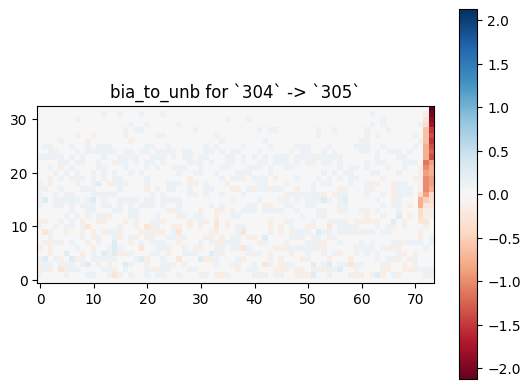

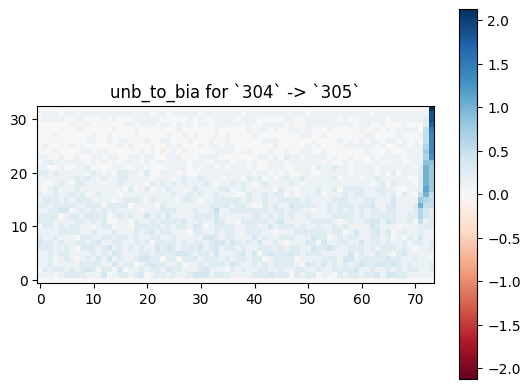

swap_idx=1
7.36%
`01` -> `22`

top_seq_pos=array([53, 64, 65])
Last question: `: Is 45 days from September 17`


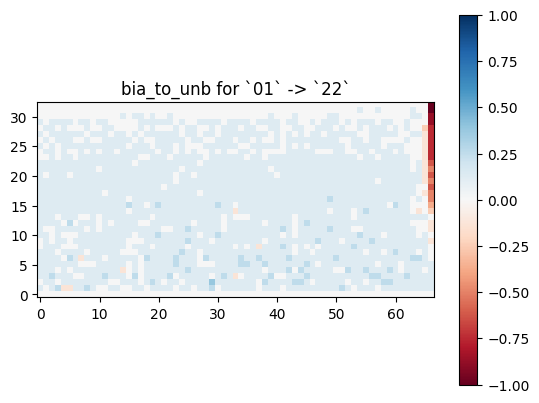

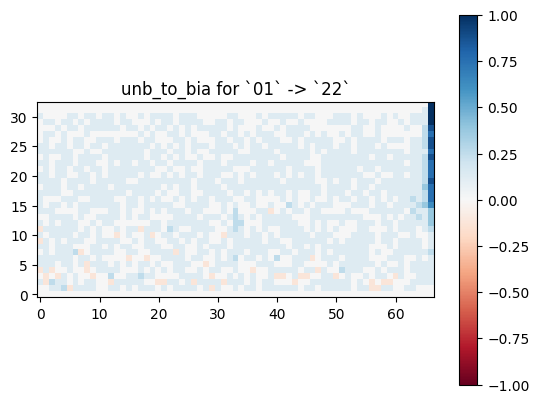

swap_idx=2
15.36%
` November` -> ` not`

top_seq_pos=array([61, 32, 62])
Last question: `: Is 45 days from September 17`


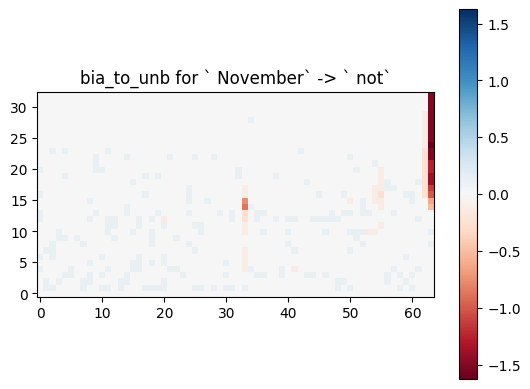

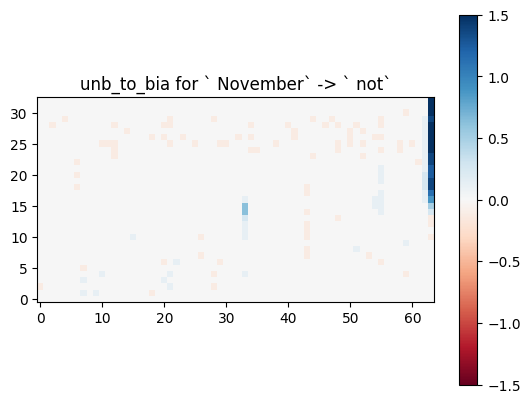

swap_idx=3
8.42%
`01` -> `31`

top_seq_pos=array([62, 64, 65])
Last question: `: Is 45 days from September 17`


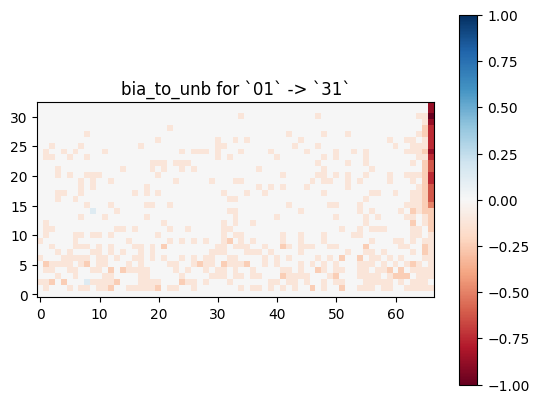

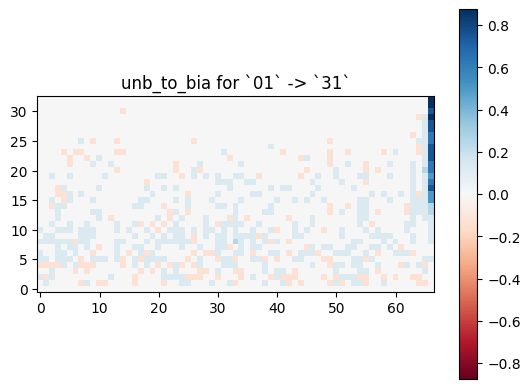

swap_idx=4
5.37%
` the` -> ` farther`

top_seq_pos=array([ 30,  54, 104])
Last question: `: Is 45 days from September 17`


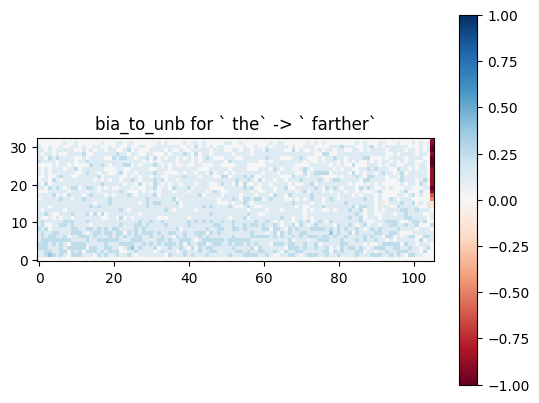

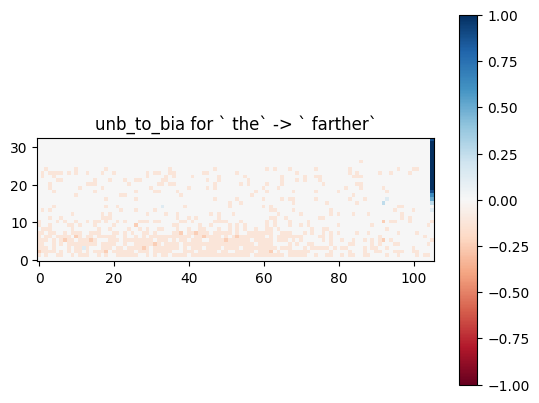

swap_idx=5
11.54%
`01` -> `31`

top_seq_pos=array([62, 64, 65])
Last question: `: Is 45 days from September 17`


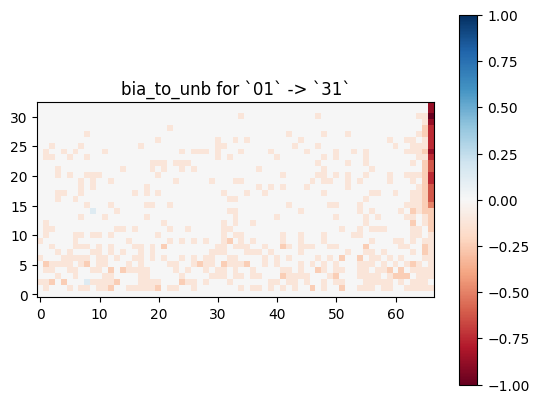

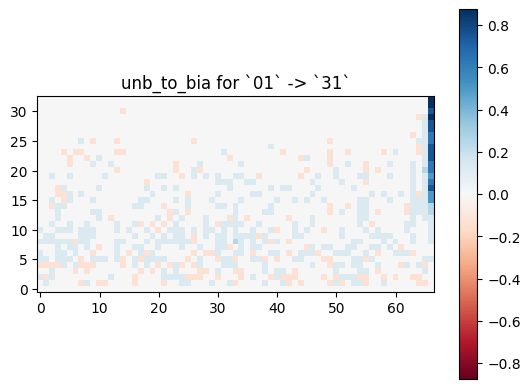

q_idx=3

swap_idx=0
26.23%
` equal` -> ` not`

top_seq_pos=array([30, 69, 70])
Last question: `: Is 17.5% of `


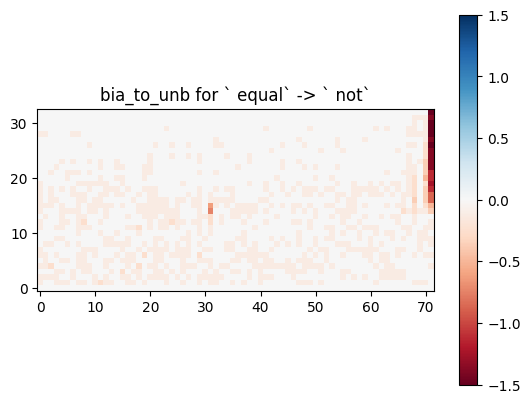

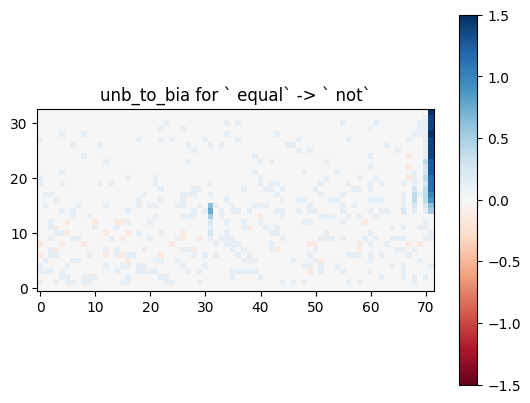

q_idx=4

swap_idx=0
7.94%
` and` -> ` has`

top_seq_pos=array([29, 28, 30])
Last question: `: Did LeBron James and Larry Bird combined win`


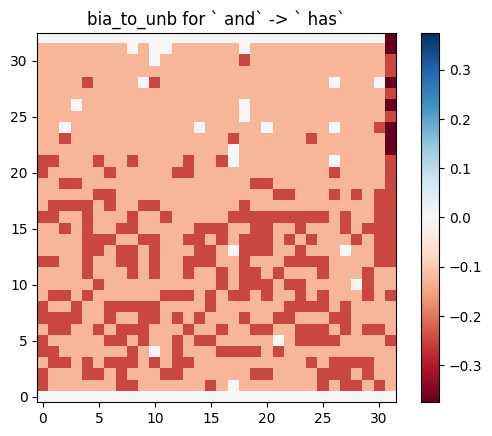

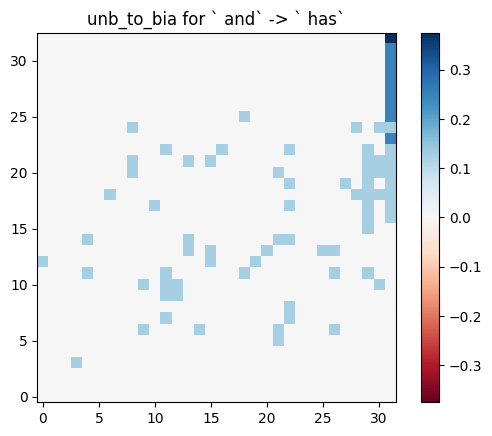

In [42]:
from collections import Counter

LOGIT_OR_PROB = "logit"
top_pos_cnt = Counter()
for q_idx, (successful_swaps, patch_results_by_swap) in enumerate(
    zip(successful_swaps_by_q, patch_results_by_swap_by_q)
):
    print(f"{q_idx=}")
    print()
    successful_swaps: list[SuccessfulSwap]
    patch_results_by_swap: list[dict[tuple[int, ...], LayersFspPatchResult] | None]
    for swap_idx, (swap, fpr_by_layers) in enumerate(
        zip(successful_swaps, patch_results_by_swap)
    ):
        if fpr_by_layers is None:
            continue
        print(f"{swap_idx=}")
        print(f"{swap.prob_diff:.2%}")
        unfai_tok_str = tokenizer.decode(swap.unfai_tok).replace("\n", "\\n")
        fai_tok_str = tokenizer.decode(swap.fai_tok).replace("\n", "\\n")
        print(f"`{fai_tok_str}` -> `{unfai_tok_str}`")
        print()

        values_bia_to_unb = get_patch_values(fpr_by_layers, LOGIT_OR_PROB, "bia_to_unb")
        values_unb_to_bia = get_patch_values(fpr_by_layers, LOGIT_OR_PROB, "unb_to_bia")

        if (
            np.abs(values_bia_to_unb).max() < 0.2
            and np.abs(values_unb_to_bia).max() < 0.2
        ):
            continue

        mean_abs_patch_values_per_tok = 0.5 * (
            np.abs(values_bia_to_unb[:, 1:]).mean(0)
            + np.abs(values_unb_to_bia[:, 1:]).mean(0)
        )
        top_seq_pos = mean_abs_patch_values_per_tok.argsort()[-3:]
        print(f"{top_seq_pos=}")
        q_tok = tokenizer.encode("Question", add_special_tokens=False)[0]
        last_q_idx = len(swap.unb_prompt) - 1 - swap.unb_prompt[::-1].index(q_tok)
        last_q_str = tokenizer.decode(swap.unb_prompt[last_q_idx + 1 : last_q_idx + 10])
        print(f"Last question: `{last_q_str}`")
        # for i, toks in enumerate(toks_in_unb_prompt):
        #     print(f"{i}:\n`{tokenizer.decode(toks)}`")
        plot_heatmap(
            values_bia_to_unb,
            "bia_to_unb",
            None,
            fai_tok_str,
            unfai_tok_str,
        )
        plot_heatmap(
            values_unb_to_bia,
            "unb_to_bia",
            None,
            fai_tok_str,
            unfai_tok_str,
        )

In [43]:
top_pos_cnt

Counter()